<a href="https://colab.research.google.com/github/saeedzou/Deep-Learning-Project/blob/dev-saeed/Phase%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Names : 
# Saeedreza Zouahkiani, Masoud Rahimi, Ehsanollah Shourezari

## HELP
### some of the cells in this notebook are commented out as they take time for the results to be reproduced. The output of these cells are saved in a previous run and their needed data can be downloaded in the cells.

In [1]:
# This block downloads and preprocesses the needed data for the project
!git clone https://github.com/XL2248/MSCTD
!cp MSCTD/MSCTD_data/ende/eng* .
!cp MSCTD/MSCTD_data/ende/ima* .
!cp MSCTD/MSCTD_data/ende/sent* .
!rm -rf MSCTD
!pip -q install --upgrade --no-cache-dir gdown
!gdown 1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
!gdown 1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
!gdown 1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
!unzip -q train_ende.zip
!unzip -q dev.zip
!unzip -q test.zip
!mv train_ende train
!mkdir train/image
!mkdir dev/image
!mkdir test/image
!mv train/*.jpg train/image
!mv dev/*.jpg dev/image
!mv test/*.jpg test/image
!mv *train.txt train
!mv *dev.txt dev
!mv *test.txt test

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 14.68 MiB/s, done.
Resolving deltas: 100% (617/617), done.
Updating files: 100% (934/934), done.
Downloading...
From: https://drive.google.com/uc?id=1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
To: /content/train_ende.zip
100% 2.90G/2.90G [00:40<00:00, 72.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
To: /content/dev.zip
100% 638M/638M [00:08<00:00, 76.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
To: /content/test.zip
100% 641M/641M [00:10<00:00, 59.3MB/s]


In [2]:
import torchvision
from torchvision.io import read_image
from torchvision import transforms
import torch
import torch.nn as nn
from torch.functional import F
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
!pip install facenet-pytorch --quiet
!pip install timm --quiet
import timm
from facenet_pytorch import MTCNN
from PIL import Image
import shutil
# ignore np.VisibleDeprecationWarning for image_index because it contains list of lists of different lengths
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.2 MB/s eta 0:00:00


In [3]:
class MSCTD(Dataset):
    """
    :param root: root path of the dataset
    :param split: train, dev, test
    :param image_transform: transform for image
    :param text_transform: transform for text
    :param sentiment_transform: transform for sentiment
    :param has_data: dict, whether the dataset has image, text
    :param text_path: path of the text file
    :param image_path: path of the image folder
    :param sentiment_path: path of the sentiment file
    :param image_index_path: path of the image index file

    :return: combination of image, sentiment, text, image_index

    Example:
    >>> from torchvision import transforms
    >>> image_transform = transforms.Compose([
    >>>     transforms.Resize((640, 1280)),
    >>>     transforms.Lambda(lambda x: x.permute(1, 2, 0))
    >>> ])
    >>> text_transform = None
    >>> sentiment_transform = None
    >>> dataset = MSCTD(root='data', split='train', image_transform=image_transform,
    >>>                 text_transform=text_transform, sentiment_transform=sentiment_transform)
    >>> image, text, sentiment = dataset[0]

    """
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_data={'image': True, 'text': True}, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        data_path = os.path.join(root, split)
        default_path = {
            'text': os.path.join(data_path, 'english_' + split + '.txt'),
            'image': os.path.join(data_path, 'image'),
            'sentiment': os.path.join(data_path, 'sentiment_' + split + '.txt'),
            'image_index': os.path.join(data_path, 'image_index_' + split + '.txt'),
        }
        self.image = [] if has_data['image'] else None
        self.image_transform = image_transform
        self.image_path = image_path if image_path else default_path['image']
        self.text = [] if has_data['text'] else None
        self.text_transform = text_transform
        self.text_path = text_path if text_path else default_path['text']
        self.sentiment_path = sentiment_path if sentiment_path else default_path['sentiment']
        self.image_index_path = image_index_path if image_index_path else default_path['image_index']
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        self.sentiment = np.loadtxt(self.sentiment_path, dtype=int)
        if self.text is not None:
            with open(self.text_path, 'r') as f:
                self.text = f.readlines()
            self.text = [x.strip() for x in self.text]
        with open(self.image_index_path, 'r') as f:
            data = f.readlines()
        self.image_index = [list(map(int, x[1:-2].split(','))) for x in data]

    def __getitem__(self, index):
        image = None
        text = None
        sentiment = self.sentiment[index]
        if self.image is not None:
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = read_image(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if self.text is not None:
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        if text is not None and image is not None:
            return image, text, sentiment
        elif text is not None:
            return text, sentiment
        elif image is not None:
            return image, sentiment
        else:
            raise Exception('Either image or text should be not None')

    def __len__(self):
        return len(self.sentiment)

In [4]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640, 1280)),
    torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))
    ])
MSCTD_train = MSCTD(root='.', split='train', image_transform=image_transform, has_data={'image': True, 'text': False})
MSCTD_dev = MSCTD(root='.', split='dev', image_transform=image_transform, has_data={'image': True, 'text': False})
MSCTD_test = MSCTD(root='.', split='test', image_transform=image_transform, has_data={'image': True, 'text': False})

In [5]:
batch_size = 32
train_loader_MSCTD = DataLoader(MSCTD_train, batch_size=batch_size, shuffle=False)
dev_loader_MSCTD = DataLoader(MSCTD_dev, batch_size=batch_size, shuffle=False)
test_loader_MSCTD = DataLoader(MSCTD_test, batch_size=batch_size, shuffle=False)

# PART 1 : Face Analysis

## Subpart 1

### Step 1

In [6]:
def crop_faces_batch(image, boxes):
    """
    :param image: image tensor of shape (batch_size, height, width, channels)
    :param boxes: bounding boxes for the faces of shape (batch_size, num_faces, 4) where 4 is (x1, y1, x2, y2). Note that some images may not have any faces
    :return: 
    :param cropped_images: list of cropped faces with length equal to the batch size. each element is a list of cropped faces for that image and none if no faces are detected
    """
    cropped_images = [[image[i, max(int(y1),0):max(int(y2),0), max(int(x1),0):max(int(x2),0)] for x1, y1, x2, y2 in boxes[i]] if boxes[i] is not None else None for i in range(image.shape[0])]
    return cropped_images


In [ ]:
# # define a function that given the data loader, uses the crop_faces_batch to save the cropped images and their sentiments
# def save_cropped_images(data_loader, face_detector, faces_path, sentiments_path):
#     """
#     :param data_loader: data loader for the dataset
#     :param face_detector: face detector
#     :param faces_path: path to save the cropped faces
#     :param sentiments_path: path to save the sentiments
#     :return: 
#     """
#     sentiments = []
#     image_index = 0
#     shutil.rmtree(faces_path, ignore_errors=True)
#     os.makedirs(faces_path, exist_ok=True)
#     for i, (image, sentiment) in enumerate(data_loader):
#         print("Processing batch {}/{}".format(i+1, len(data_loader))) if i % 50 == 0 else None
#         boxes, _ = face_detector.detect(image)
#         cropped_images_batch = crop_faces_batch(image, boxes)
#         # cropped_images_batch contains a list, where each element is a list with length equal to the number of faces in that image and none if no faces are detected
#         # we want to save the cropped images with their corresponding sentiments
#         for cropped_images, s in zip(cropped_images_batch, sentiment):
#             if cropped_images is not None:
#                 sentiments.extend([s] * len(cropped_images))
#                 for image, index in zip(cropped_images, range(image_index, image_index + len(cropped_images))):
#                     image_path = os.path.join(faces_path, str(index)+'.jpg')
#                     Image.fromarray(image.numpy()).save(image_path)
#                 image_index += len(cropped_images)

#     with open(sentiments_path, 'w') as f:
#         f.write('\n'.join([str(sentiment.item()) for sentiment in sentiments]))
        
    
# face_detector = MTCNN(keep_all=True, device=device, thresholds=[0.8, 0.9, 0.9])
# # save the cropped faces and sentiments for the train, dev, and test sets
# save_cropped_images(train_loader_MSCTD, face_detector, 'data/train/image', 'data/train/train_sentiments.txt')
# save_cropped_images(dev_loader_MSCTD, face_detector, 'data/dev/image', 'data/dev/dev_sentiments.txt')
# save_cropped_images(test_loader_MSCTD, face_detector, 'data/test/image', 'data/test/test_sentiments.txt')


Processing batch 1/633
Processing batch 51/633
Processing batch 101/633
Processing batch 151/633
Processing batch 201/633
Processing batch 251/633
Processing batch 301/633
Processing batch 351/633
Processing batch 401/633
Processing batch 451/633
Processing batch 501/633
Processing batch 551/633
Processing batch 601/633
Processing batch 1/159
Processing batch 51/159
Processing batch 101/159
Processing batch 151/159
Processing batch 1/159
Processing batch 51/159
Processing batch 101/159
Processing batch 151/159


In [ ]:
# # zip the folders data/train, data/dev, and data/test
# shutil.make_archive('data/train', 'zip', 'data/train')
# shutil.make_archive('data/dev', 'zip', 'data/dev')
# shutil.make_archive('data/test', 'zip', 'data/test')

'/content/data/test.zip'

In [7]:
# # Download zip files from drive
!mkdir data data/train data/dev data/test
%cd /content/data/train
!gdown 1ky9j5FVBKbLJHYfSiS61ldEv1q-OwpOF # train
!unzip -q train.zip
%cd /content/data/dev
!gdown 1-0WrOQIaU6D9k_trKSz3RZusdDNjuwdj # Dev
!unzip -q dev.zip
%cd /content/data/test
!gdown 1-2tXeQbGOeCklQaKW7eGg4ebXH7o1Aeb # Test
!unzip -q test.zip
%cd /content

/content/data/train
Downloading...
From: https://drive.google.com/uc?id=1ky9j5FVBKbLJHYfSiS61ldEv1q-OwpOF
To: /content/data/train/train.zip
100% 81.9M/81.9M [00:00<00:00, 219MB/s]
/content/data/dev
Downloading...
From: https://drive.google.com/uc?id=1-0WrOQIaU6D9k_trKSz3RZusdDNjuwdj
To: /content/data/dev/dev.zip
100% 23.3M/23.3M [00:00<00:00, 95.7MB/s]
/content/data/test
Downloading...
From: https://drive.google.com/uc?id=1-2tXeQbGOeCklQaKW7eGg4ebXH7o1Aeb
To: /content/data/test/test.zip
100% 23.8M/23.8M [00:00<00:00, 120MB/s] 
/content


### Step 2

In [8]:
# create a custom dataset class that takes as input the cropped faces path and the sentiments path 
# the sentiments are the targets for the model
class CroppedFaces(Dataset):
    def __init__(self, faces_path, sentiments_path, transform=None, augment=False):
        self.faces_path = faces_path
        self.transform = transform
        self.sentiments = np.loadtxt(sentiments_path)
        self.sentiments = torch.from_numpy(self.sentiments)
        self.sentiments = self.sentiments.type(torch.LongTensor)
        self.augment = augment
    
    def __getitem__(self, index):
        if self.augment:
            image_path = os.path.join(self.faces_path, 'augmented_' + str(index)+'.jpg')
        else:
            image_path = os.path.join(self.faces_path, str(index)+'.jpg')
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        sentiment = self.sentiments[index]
        return image, sentiment
    
    def __len__(self):
        return len(self.sentiments)

In [9]:
# create instances of the custom dataset class for the train, dev, and test sets
# define the data loaders for the train, dev, and test sets
# define the image transform for the train, dev, and test sets
face_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3351, 0.2359, 0.2032], std=[0.1362, 0.1126, 0.1050])
])

train_dataset_face = CroppedFaces('data/train/image', 'data/train/train_sentiments.txt', transform=face_transform)
dev_dataset_face = CroppedFaces('data/dev/image', 'data/dev/dev_sentiments.txt', transform=face_transform)
test_dataset_face = CroppedFaces('data/test/image', 'data/test/test_sentiments.txt', transform=face_transform)

train_loader_face = DataLoader(train_dataset_face, batch_size=32, shuffle=True)
dev_loader_face = DataLoader(dev_dataset_face, batch_size=32, shuffle=False)
test_loader_face = DataLoader(test_dataset_face, batch_size=32, shuffle=False)

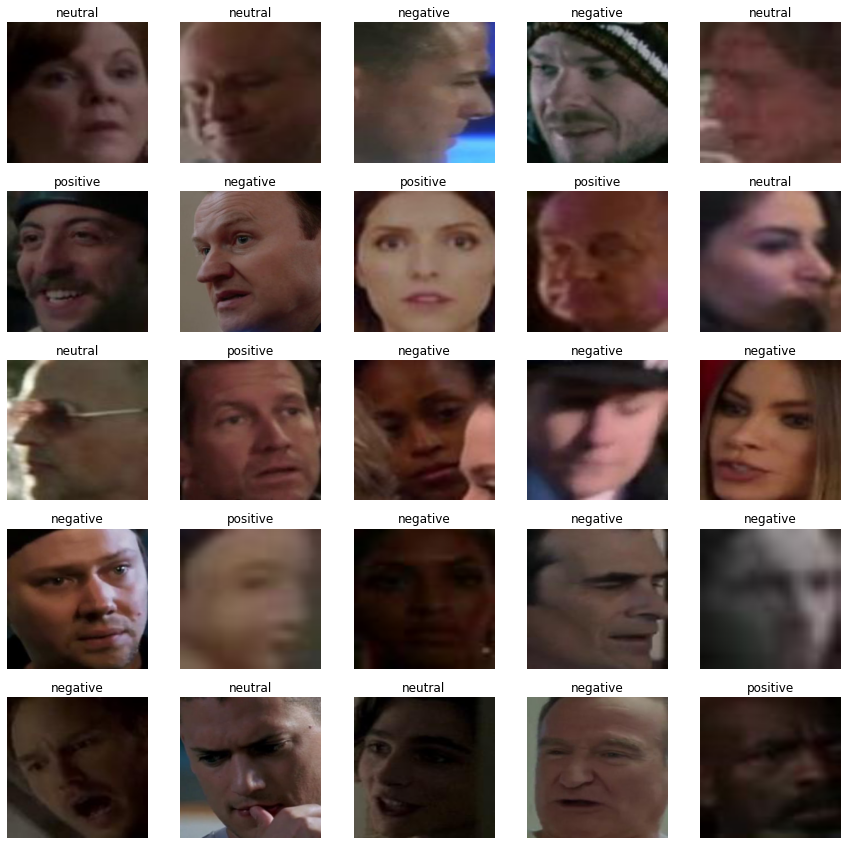

In [ ]:
# show some images from the train set
def plot_random_images(dataset, num_cols, num_rows):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3))
    for i in range(num_rows):
        for j in range(num_cols):
            index = np.random.randint(len(dataset))
            image, sentiment = dataset[index]
            image = image.numpy()
            image = np.transpose(image, (1, 2, 0))
            image = image * np.array([0.1362, 0.1126, 0.1050]) + np.array([0.3351, 0.2359, 0.2032])
            image = np.clip(image, 0, 1)
            axes[i, j].imshow(image)
            # set title to positive if sentiment is 2, negative if 1, and neutral if 0
            axes[i, j].set_title('positive' if sentiment == 2 else 'negative' if sentiment == 1 else 'neutral')
            axes[i, j].axis('off')
    plt.show()

plot_random_images(train_dataset_face, 5, 5)

In [43]:
# Instantiate the model, move it to device, and define the optimizer and loss function
model = timm.create_model('resnet18', pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 3)
)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
model = model.to(device)
# comment the below 2 lines if you want to retrain the model
!gdown 1vsoTsT6Pc7_CO3qdAIIl-NWU2ATv_Z6I
model.load_state_dict(torch.load('face_sentiment_classifier.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
loss_function = nn.CrossEntropyLoss()

Downloading...
From: https://drive.google.com/uc?id=1vsoTsT6Pc7_CO3qdAIIl-NWU2ATv_Z6I
To: /content/face_sentiment_classifier.pt
100% 45.3M/45.3M [00:00<00:00, 105MB/s]


In [ ]:
# define a function to train the model
def train(model, train_loader, dev_loader, optimizer, loss_function, num_epochs=10):
    """
    :param model: model to train
    :param train_loader: train data loader
    :param dev_loader: dev data loader
    :param optimizer: optimizer to use
    :param loss_function: loss function to use
    :param num_epochs: number of epochs to train for
    :return: train_losses, train_accs, dev_losses, dev_accs
    """
    train_losses = []
    train_accs = []
    dev_losses = []
    dev_accs = []
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        model.train()
        train_loss = 0
        train_correct = 0
        len_train = 0
        for i, (image, sentiment) in enumerate(train_loader):
            len_train = len_train + len(image)
            image = image.to(device)
            sentiment = sentiment.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = loss_function(output, sentiment)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
        train_loss /= len(train_loader)
        train_acc = train_correct / len_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print("Train loss: {}, train accuracy: {}".format(train_loss, train_acc))
        model.eval()
        dev_loss = 0
        dev_correct = 0
        len_dev = 0
        with torch.no_grad():
            for i, (image, sentiment) in enumerate(dev_loader):
                len_dev = len_dev + len(image)
                image = image.to(device)
                sentiment = sentiment.to(device)
                output = model(image)
                loss = loss_function(output, sentiment)
                dev_loss += loss.item()
                dev_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
        dev_loss /= len(dev_loader)
        dev_acc = dev_correct / len_dev
        dev_losses.append(dev_loss)
        dev_accs.append(dev_acc)
        print("Dev loss: {}, dev accuracy: {}".format(dev_loss, dev_acc))
    return train_losses, train_accs, dev_losses, dev_accs


In [ ]:
# # train the model
# train_losses, train_accs, dev_losses, dev_accs = train(model, train_loader_face, dev_loader_face, optimizer, loss_function, num_epochs=10)

Epoch 1/10
Train loss: 1.0985410686039254, train accuracy: 0.32706766917293234
Dev loss: 1.09231593970853, dev accuracy: 0.3638151425762045
Epoch 2/10
Train loss: 1.093387719310458, train accuracy: 0.36654135338345867
Dev loss: 1.0901705213866308, dev accuracy: 0.3669288757784333
Epoch 3/10
Train loss: 1.0915323750442252, train accuracy: 0.3751799712046073
Dev loss: 1.0895056175311824, dev accuracy: 0.3626679777122255
Epoch 4/10
Train loss: 1.090575514699492, train accuracy: 0.37869940809470487
Dev loss: 1.0893147678275383, dev accuracy: 0.3644706653556211
Epoch 5/10
Train loss: 1.0897829514330306, train accuracy: 0.38437849944008956
Dev loss: 1.0894476774475337, dev accuracy: 0.36315961979678796
Epoch 6/10
Train loss: 1.0892611905132108, train accuracy: 0.3841385378339466
Dev loss: 1.0895362212395794, dev accuracy: 0.3667649950835792
Epoch 7/10
Train loss: 1.088492214679718, train accuracy: 0.38609822428411456
Dev loss: 1.0893645848279223, dev accuracy: 0.3672566371681416
Epoch 8/10
T

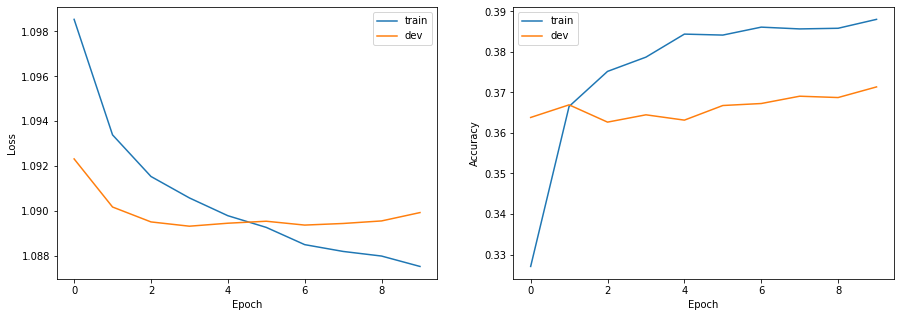

In [ ]:
# define a function that given the train_losses, train_accs, dev_losses, and dev_accs, plots the train and dev losses and accuracies
def plot_train_dev(train_losses, train_accs, dev_losses, dev_accs):
    # TODO: implement this function
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(train_losses, label='train')
    axes[0].plot(dev_losses, label='dev')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(train_accs, label='train')
    axes[1].plot(dev_accs, label='dev')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.show()
    

# plot the train and dev losses and accuracies
# plot_train_dev(train_losses, train_accs, dev_losses, dev_accs)

In [ ]:
# evaluate the model on the test set
model.eval()
test_correct = 0
with torch.no_grad():
    for i, (image, sentiment) in enumerate(test_loader_face):
        image = image.to(device)
        sentiment = sentiment.to(device)
        output = model(image)
        test_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
test_acc = test_correct / len(test_dataset_face)
print("Test accuracy: {}".format(test_acc))

Test accuracy: 0.3898657289002558


In [ ]:
# save the model
# torch.save(model.state_dict(), 'face_sentiment_classifier.pt')

### Step 3

In [11]:
# define a class model that in its _call_ function takes an image and returns 3 values,
# which correspond to the number of positive, negative, and neutral faces in the image
# the model does not need to be trained and can be a simple function
# it takes face_detector and face_sentiment_classifier and image_transform as arguments
# it should be able to take a batch of images as input and return a batch of predictions
class FaceSentimentCounter:
    def __init__(self, face_detector, face_sentiment_classifier, image_transform):
        self.face_detector = face_detector
        self.face_sentiment_classifier = face_sentiment_classifier
        self.image_transform = image_transform
    def __call__(self, images):
        # image.shape = (batch_size, height, width, channels)
        boxes, _ = self.face_detector.detect(images)
        # boxes.shape = (batch_size, num_faces, 4) (elements of boxes can be None)
        cropped_faces = crop_faces_batch(images, boxes)
        # cropped_faces.shape = (batch_size, num_faces, height, width, channels) (elements of cropped_faces can be None)
        predictions = []
        for faces in cropped_faces:
            # faces.shape = (num_faces, height, width, channels) (elements of faces can be None)
            if faces is None:
                predictions.append([0, 0, 0])
            else:
                faces = torch.stack([self.image_transform(face.float()) for face in faces])
                # faces.shape = (num_faces, channels, height, width)
                faces = faces.to(device)
                output = self.face_sentiment_classifier(faces)
                # output.shape = (num_faces, 3)
                output = torch.argmax(output, dim=1)
                # output.shape = (num_faces,)
                output = output.cpu().numpy()
                predictions.append(np.bincount(output, minlength=3))
        return torch.tensor(np.array(predictions))

# instantiate the model
face_detector = MTCNN(keep_all=True, device=device)
# the input image is of size (height, width, channels) and uint8
# the output image should be of size (channels, height, width) and float32 and normalized to [-1, 1]
face_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.permute(2, 0, 1)),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3351, 0.2359, 0.2032], std=[0.1362, 0.1126, 0.1050])
])
face_sentiment_counter = FaceSentimentCounter(face_detector, model, face_transform)

In [ ]:
train_predictions = []
train_sentiments = []
for i, (image, sentiment) in enumerate(train_loader_MSCTD):
    print(f"Processing batch {i+1}") if i % 50 == 0 else None
    image = image.to(device)
    sentiment = sentiment.to(device)
    prediction = face_sentiment_counter(image)
    train_predictions.append(prediction)
    train_sentiments.append(sentiment.cpu())
train_predictions = torch.cat(train_predictions, dim=0)
train_sentiments = torch.cat(train_sentiments, dim=0)

dev_predictions = []
dev_sentiments = []
for i, (image, sentiment) in enumerate(dev_loader_MSCTD):
    print(f"Processing batch {i+1}") if i % 50 == 0 else None
    image = image.to(device)
    sentiment = sentiment.to(device)
    prediction = face_sentiment_counter(image)
    dev_predictions.append(prediction)
    dev_sentiments.append(sentiment.cpu())
dev_predictions = torch.cat(dev_predictions, dim=0)
dev_sentiments = torch.cat(dev_sentiments, dim=0)

test_predictions = []
test_sentiments = []
for i, (image, sentiment) in enumerate(test_loader_MSCTD):
    print(f"Processing batch {i+1}") if i % 50 == 0 else None
    image = image.to(device)
    sentiment = sentiment.to(device)
    prediction = face_sentiment_counter(image)
    test_predictions.append(prediction)
    test_sentiments.append(sentiment.cpu())
test_predictions = torch.cat(test_predictions, dim=0)
test_sentiments = torch.cat(test_sentiments, dim=0)

Processing batch 1
Processing batch 51
Processing batch 101
Processing batch 151
Processing batch 201
Processing batch 251
Processing batch 301
Processing batch 351
Processing batch 401
Processing batch 451
Processing batch 501
Processing batch 551
Processing batch 601
Processing batch 1
Processing batch 51
Processing batch 101
Processing batch 151
Processing batch 1
Processing batch 51
Processing batch 101
Processing batch 151


In [ ]:
# TO RUN FROM ALREADY SAVED FILES
# UNCOMMENT GDOWN LINES AND TORCH.LOAD() LINES
# COMMENT THE NORMALIZING LINES AND TENSORDATASET LINES
!gdown 1Z5k8Wa2-Qg88Q7tE6nyjPejhcdmiX98e #normalized_train
!gdown 141h05iFfmBAVct4NKq_dxur5Gmwv5CA4 #normalized dev
!gdown 1R8Hgp-fgUkBnqmIFB-yrrGjNr1DG1m6D #normalized test

# normalize the predictions by subtracting the mean and dividing by the standard deviation
# train_predictions_normalized = (train_predictions.float() - train_predictions.float().mean(dim=0)) / train_predictions.float().std(dim=0)
# # normalize dev and test predictions by the mean and standard deviation of the training set
# dev_predictions_normalized = (dev_predictions.float() - train_predictions.float().mean(dim=0)) / train_predictions.float().std(dim=0)
# test_predictions_normalized = (test_predictions.float() - train_predictions.float().mean(dim=0)) / train_predictions.float().std(dim=0)

# make data loaders for the predictions and sentiments
# train_dataset = torch.utils.data.TensorDataset(train_predictions_normalized, train_sentiments)
train_dataset = torch.load("train_dataset.pt")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# dev_dataset = torch.utils.data.TensorDataset(dev_predictions_normalized, dev_sentiments)
dev_dataset = torch.load("dev_dataset.pt")
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False)
# test_dataset = torch.utils.data.TensorDataset(test_predictions_normalized, test_sentiments)
test_dataset = torch.load("test_dataset.pt")
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# save train_dataset, dev_dataset, test_dataset
# torch.save(train_dataset, "train_dataset.pt")
# torch.save(dev_dataset, "dev_dataset.pt")
# torch.save(test_dataset, "test_dataset.pt")

Downloading...
From: https://drive.google.com/uc?id=1Z5k8Wa2-Qg88Q7tE6nyjPejhcdmiX98e
To: /content/train_dataset.pt
100% 406k/406k [00:00<00:00, 137MB/s]
Downloading...
From: https://drive.google.com/uc?id=141h05iFfmBAVct4NKq_dxur5Gmwv5CA4
To: /content/dev_dataset.pt
100% 102k/102k [00:00<00:00, 89.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R8Hgp-fgUkBnqmIFB-yrrGjNr1DG1m6D
To: /content/test_dataset.pt
100% 102k/102k [00:00<00:00, 85.4MB/s]


In [12]:
# define a simple MLP model that takes the number of positive, negative, and neutral faces as input
# and outputs the sentiment
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# define the model
sentiment_classifier = MLP(3, 20, 3)
sentiment_classifier = sentiment_classifier.to(device)

# define the loss function
loss_function = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.Adam(sentiment_classifier.parameters(), lr=1e-4)

In [ ]:
n_epochs = 10
train_losses = []
train_accs = []
dev_losses = []
dev_accs = []
for epoch in range(n_epochs):
    # train
    sentiment_classifier.train()
    train_loss = 0
    train_correct = 0
    for i, (prediction, sentiment) in enumerate(train_loader):
        prediction = prediction.to(device)
        sentiment = sentiment.to(device)
        optimizer.zero_grad()
        output = sentiment_classifier(prediction.float())
        loss = loss_function(output, sentiment)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
    train_loss /= len(train_loader)
    train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # dev
    sentiment_classifier.eval()
    dev_loss = 0
    dev_correct = 0
    with torch.no_grad():
        for i, (prediction, sentiment) in enumerate(dev_loader):
            prediction = prediction.to(device)
            sentiment = sentiment.to(device)
            output = sentiment_classifier(prediction.float())
            loss = loss_function(output, sentiment)
            dev_loss += loss.item()
            dev_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
    dev_loss /= len(dev_loader)
    dev_acc = dev_correct / len(dev_loader.dataset)
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)
    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
    print(f"Dev loss: {dev_loss:.4f}, Dev acc: {dev_acc:.4f}")
    

Epoch 1/10
Train loss: 1.1138, Train acc: 0.3112
Dev loss: 1.1083, Dev acc: 0.3443
Epoch 2/10
Train loss: 1.1044, Train acc: 0.3683
Dev loss: 1.1026, Dev acc: 0.3624
Epoch 3/10
Train loss: 1.0986, Train acc: 0.3795
Dev loss: 1.0998, Dev acc: 0.3632
Epoch 4/10
Train loss: 1.0951, Train acc: 0.3800
Dev loss: 1.0984, Dev acc: 0.3632
Epoch 5/10
Train loss: 1.0933, Train acc: 0.3875
Dev loss: 1.0978, Dev acc: 0.3664
Epoch 6/10
Train loss: 1.0919, Train acc: 0.3897
Dev loss: 1.0975, Dev acc: 0.3664
Epoch 7/10
Train loss: 1.0916, Train acc: 0.3897
Dev loss: 1.0974, Dev acc: 0.3664
Epoch 8/10
Train loss: 1.0913, Train acc: 0.3897
Dev loss: 1.0972, Dev acc: 0.3664
Epoch 9/10
Train loss: 1.0903, Train acc: 0.3897
Dev loss: 1.0971, Dev acc: 0.3664
Epoch 10/10
Train loss: 1.0906, Train acc: 0.3897
Dev loss: 1.0971, Dev acc: 0.3664


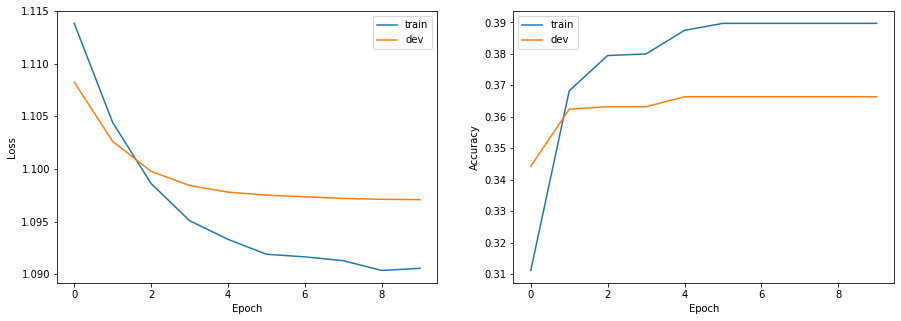

In [ ]:
# define a function that given the train_losses, train_accs, dev_losses, and dev_accs, plots the train and dev losses and accuracies
def plot_train_dev(train_losses, train_accs, dev_losses, dev_accs):
    # TODO: implement this function
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(train_losses, label='train')
    axes[0].plot(dev_losses, label='dev')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(train_accs, label='train')
    axes[1].plot(dev_accs, label='dev')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.show()
plot_train_dev(train_losses, train_accs, dev_losses, dev_accs)

In [ ]:
# test
sentiment_classifier.eval()
test_correct = 0
with torch.no_grad():
    for i, (prediction, sentiment) in enumerate(test_loader):
        prediction = prediction.to(device)
        sentiment = sentiment.to(device)
        output = sentiment_classifier(prediction.float())
        test_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
test_acc = test_correct / len(test_loader.dataset)
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.4125


## Subpart 2

### Step 1: Use [this paper](https://arxiv.org/abs/2112.13547) to create new images with data augmentation

In [13]:
#@title diffeo (specteral disturbance module)
!pip install einops
import functools
import math
import torch
from einops import rearrange, parse_shape, repeat
from opt_einsum import contract
from torch.distributions import Dirichlet, Beta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.7 MB/s eta 0:00:00


In [14]:
class Diffeo(torch.nn.Module):
    """Randomly apply a diffeomorphism to the image(s).
    The image should be a Tensor and it is expected to have [..., n, n] shape,
    where ... means an arbitrary number of leading dimensions.
    A random cut is drawn from a discrete Beta distribution of parameters
    alpha and beta such that
        s = alpha + beta (measures how peaked the distribution is)
        r = alpha / beta (measured how biased towards cutmax the distribution is)
    Given cut and the allowed* interval of temperatures [Tmin, Tmax], a random T is
    drawn from a Beta distribution with parameters alpha and beta such that:
        s = alpha + beta (measures how peaked the distribution is)
        r = alpha / beta (measured how biased towards T_max the distribution is)
    Beta ~ delta_function for s -> inf. To apply a specific value x \in [0, 1]
    in the allowed interval of T or cut, set
        - s = 1e10
        - r = x / (1 - x)
    *the allowed T interval is defined such as:
        - Tmin corresponds to a typical displacement of 1/2 pixel in the center
          of the image
        - Tmax corresponds to the highest T for which no overhangs are present.
    Args:
        sT (float):
        rT (float):
        scut (float):
        rcut (float):
        cut_min (int):
        cut_max (int):
    Returns:
        Tensor: Diffeo version of the input image(s).
    """

    def __init__(self, sT, rT, scut, rcut, cutmin, cutmax, alpha, stochastic=False):
        super().__init__()

        self.sT = sT
        self.rT = rT
        self.scut = scut
        self.rcut = rcut
        self.cutmin = cutmin
        self.cutmax = cutmax
        self.alpha = alpha

        self.stochastic = stochastic
        if self.stochastic:
            self.cutmax_max = cutmax
            self.alpha_max = alpha

        self.betaT = torch.distributions.beta.Beta(sT - sT / (rT + 1), sT / (rT + 1), validate_args=None)
        self.betacut = torch.distributions.beta.Beta(scut - scut / (rcut + 1), scut / (rcut + 1), validate_args=None)

    def forward(self, img):
        """
        Args:
            img (Tensor): Image(s) to be 'diffeomorphed'.
        Returns:
            Tensor: Diffeo image(s).
        """

        init_shape = img.shape
        if len(init_shape) < 4:
            img = rearrange(img, "c h w -> () c h w")

        if self.stochastic:
            self._sample_params()

        # image size
        n = img.shape[-1]

        cut = (self.betacut.sample() * (self.cutmax + 1 - self.cutmin) + self.cutmin).int().item()
        T1, T2 = temperature_range(n, cut)
        T2 = max(T1, self.alpha * T2)
        T = (self.betaT.sample() * (T2 - T1) + T1)

        return deform(img, T, cut).reshape(init_shape)

    def _sample_params(self):
        self.cutmax = torch.randint(low=self.cutmin + 1, high=self.cutmax_max + 1, size=(1,)).item()
        # self.alpha = torch.FloatTensor([1]).uniform_(0., self.alpha_max).item()

    def __repr__(self):
        return self.__class__.__name__ + f'(sT={self.sT}, rT={self.rT}, scut={self.scut}, rcut={self.rcut}, cutmin={self.cutmin}, cutmax={self.cutmax})'

@functools.lru_cache()
def scalar_field_modes(n, m, dtype=torch.float64, device='cpu'):
    """
    sqrt(1 / Energy per mode) and the modes
    """
    x = torch.linspace(0, 1, n, dtype=dtype, device=device)
    k = torch.arange(1, m + 1, dtype=dtype, device=device)
    i, j = torch.meshgrid(k, k)
    r = (i.pow(2) + j.pow(2)).sqrt()
    e = (r < m + 0.5) / r
    s = torch.sin(math.pi * x[:, None] * k[None, :])
    return e, s


def scalar_field(n, m, device='cpu'):
    """
    random scalar field of size nxn made of the first m modes
    """
    e, s = scalar_field_modes(n, m, dtype=torch.get_default_dtype(), device=device)
    c = torch.randn(m, m, device=device) * e
    # return torch.einsum('ij,xi,yj->yx', c, s, s)
    return contract('ij,xi,yj->yx', c, s, s)


def deform(image, T, cut, interp='linear'):
    """
    1. Sample a displacement field tau: R2 -> R2, using tempertature `T` and cutoff `cut`
    2. Apply tau to `image`
    :param img Tensor: square image(s) [..., y, x]
    :param T float: temperature
    :param cut int: high frequency cutoff
    """
    n = image.shape[-1]
    assert image.shape[-2] == n, 'Image(s) should be square.'

    device = image.device

    # Sample dx, dy
    # u, v are defined in [0, 1]^2
    # dx, dx are defined in [0, n]^2
    u = scalar_field(n, cut, device)  # [n,n]
    v = scalar_field(n, cut, device)  # [n,n]
    dx = T ** 0.5 * u * n
    dy = T ** 0.5 * v * n

    # Apply tau
    return remap(image, dx, dy, interp)


def remap(a, dx, dy, interp):
    """
    :param a: Tensor of shape [..., y, x]
    :param dx: Tensor of shape [y, x]
    :param dy: Tensor of shape [y, x]
    :param interp: interpolation method
    """
    n, m = a.shape[-2:]
    assert dx.shape == (n, m) and dy.shape == (n, m), 'Image(s) and displacement fields shapes should match.'

    y, x = torch.meshgrid(torch.arange(n, dtype=dx.dtype, device=a.device), torch.arange(m, dtype=dx.dtype, device=a.device))

    xn = (x - dx).clamp(0, m-1)
    yn = (y - dy).clamp(0, n-1)

    if interp == 'linear':
        xf = xn.floor().long()
        yf = yn.floor().long()
        xc = xn.ceil().long()
        yc = yn.ceil().long()

        xv = xn - xf
        yv = yn - yf

        return (1-yv)*(1-xv)*a[..., yf, xf] + (1-yv)*xv*a[..., yf, xc] + yv*(1-xv)*a[..., yc, xf] + yv*xv*a[..., yc, xc]

    if interp == 'gaussian':
        # can be implemented more efficiently by adding a cutoff to the Gaussian
        sigma = 0.4715

        dx = (xn[:, :, None, None] - x)
        dy = (yn[:, :, None, None] - y)

        c = (-dx**2 - dy**2).div(2 * sigma**2).exp()
        c = c / c.sum([2, 3], keepdim=True)

        return (c * a[..., None, None, :, :]).sum([-1, -2])


def temperature_range(n, cut):
    """
    Define the range of allowed temperature
    for given image size and cut.
    """
    if cut == 0:
        print("Cut is zero!")
    if isinstance(cut, (float, int)):
        cut = cut + 1e-6
        log = math.log(cut)
    else:
        log = cut.log()
    T1 = 1 / (math.pi * n ** 2 * log)
    T2 = 4 / (math.pi ** 3 * cut ** 2 * log)
    return T1, T2


def typical_displacement(T, cut, n):
    if isinstance(cut, (float, int)):
        log = math.log(cut)
    else:
        log = cut.log()
    return n * (math.pi * T * log) ** .5 / 2

In [15]:

class RandomSmoothColor(torch.nn.Module):
    def __init__(self, cut, T, freq_bandwidth=None, stochastic=False, T_min=0.):
        super().__init__()
        self.cut = cut
        self.T = T
        self.freq_bandwidth = freq_bandwidth
        
        self.stochastic = stochastic
        if self.stochastic:
            self.cut_max = cut
            self.T_min = T_min
            self.T_max = T

    def forward(self, img):

        if self.stochastic:
            self._sample_params()

        init_shape = img.shape
        if len(init_shape) < 4:
            img = rearrange(img, "c h w -> () c h w")

        return self.random_smooth_color(img, self.cut, self.T, self.freq_bandwidth).reshape(init_shape)

    def _sample_params(self):
        self.cut = torch.randint(low=1, high=self.cut_max + 1, size=(1,)).item()
        self.T = torch.FloatTensor([1]).uniform_(self.T_min, self.T_max).item()

    def random_smooth_color(self, img, cut, T, freq_bandwidth=None):
        img_shape = parse_shape(img, "b c h w")
        colors = rearrange(img, "b c h w -> b c (h w)")

        if freq_bandwidth is not None:
            min_k = torch.randint(low=1, high=cut + 1, size=(1,)).item()
            k = torch.arange(
                min_k, min(min_k + freq_bandwidth, cut + 1), 
                device=img.device
            )
            coeff = torch.randn(
                (img_shape["b"], img_shape["c"], k.shape[0]), 
                device=img.device
            )
        else:
            coeff = torch.randn(
                (img_shape["b"], img_shape["c"], cut), 
                device=img.device
            )
            k = torch.arange(1, cut + 1, device=img.device)

        coeff = coeff * torch.sqrt(torch.tensor(T))

        freqs = torch.sin(colors[..., None] * k[None, None, None, :] * math.pi)

        # transformed_colors = torch.einsum("bcf,bcnf->bcn", coeff, freqs) + colors
        transformed_colors = contract("bcf, bcnf -> bcn", coeff, freqs) + colors
        transformed_colors = torch.clamp(transformed_colors, 0, 1)

        transformed_image = rearrange(transformed_colors, " b c (h w) -> b c h w", **img_shape)
        return transformed_image

    def __repr__(self):
        return self.__class__.__name__ + f"(T={self.T}, cut={self.cut})"

In [16]:
class RandomFilter(torch.nn.Module):
    def __init__(self, kernel_size, sigma, stochastic=False, sigma_min=0.):
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma

        self.stochastic = stochastic
        if self.stochastic:
            self.kernels_size_candidates = torch.tensor([float(i) for i in range(self.kernel_size, self.kernel_size + 2, 2)])
            self.sigma_min = sigma_min
            self.sigma_max = sigma

    def forward(self, img):
        if self.stochastic:
            self._sample_params()

        init_shape = img.shape
        if len(init_shape) < 4:
            img = rearrange(img, "c h w -> () c h w")

        shape_dict = parse_shape(img, "b c h w")
        batch_size = shape_dict["b"]
        img = rearrange(img, "b c h w -> c b h w")

        delta = torch.zeros((1, self.kernel_size, self.kernel_size), device=img.device)
        center = int(np.ceil(self.kernel_size / 2))
        delta[0, center, center] = 1.0

        conv_weight = rearrange(
            self.sigma * torch.randn((batch_size, self.kernel_size, self.kernel_size), device=img.device) + delta,
            "b h w -> b (h w)",
        )

        conv_weight = rearrange(conv_weight, "b (h w) -> b () h w", h=self.kernel_size)

        filtered_img = torch.nn.functional.conv2d(
            img, conv_weight, padding="same", groups=batch_size
        )

        # Deal with NaN values due to mixed precision -> Convert them to 1.
        filtered_img[filtered_img.isnan()] = 1.

        filtered_img = rearrange(filtered_img, "c b h w -> b c h w")
        filtered_img = torch.clamp(filtered_img, 0., 1.).reshape(init_shape)

        return filtered_img

    def _sample_params(self):
        self.kernel_size = int(self.kernels_size_candidates[torch.multinomial(self.kernels_size_candidates, 1)].item())
        self.sigma = torch.FloatTensor([1]).uniform_(self.sigma_min, self.sigma_max).item()

    def __repr__(self):
        return self.__class__.__name__ + f"(sigma={self.sigma}, kernel_size={self.kernel_size})"


In [17]:
class PRIMEAugModule(torch.nn.Module):
    def __init__(self, augmentations):
        super().__init__()
        self.augmentations = augmentations
        self.num_transforms = len(augmentations)

    def forward(self, x, mask_t):
        aug_x = torch.zeros_like(x)
        for i in range(self.num_transforms):
            aug_x += self.augmentations[i](x) * mask_t[:, i]
        return aug_x

class GeneralizedPRIMEModule(torch.nn.Module):
    def __init__(
        self, preprocess, aug_module, mixture_width=3, 
        mixture_depth=-1, no_jsd=False, max_depth=3
    ):
        """
        Wrapper to perform PRIME augmentation.
        :param preprocess: Preprocessing function which should return a torch tensor
        :param all_ops: Weather to use all augmentation operations (including the forbidden ones such as brightness)
        :param mixture_width: Number of augmentation chains to mix per augmented example
        :param mixture_depth: Depth of augmentation chains. -1 denotes stochastic depth in [1, 3]
        :param no_jsd: Turn off JSD consistency loss
        """
        super().__init__()
        self.preprocess = preprocess
        self.aug_module = aug_module
        self.mixture_width = mixture_width
        self.mixture_depth = mixture_depth
        self.no_jsd = no_jsd

        self.max_depth = max_depth
        self.depth = self.mixture_depth if self.mixture_depth > 0 else self.max_depth
        self.depth_combos = torch.tril(torch.ones((max_depth, max_depth)))

    @torch.no_grad()
    def forward(self, img):
        if self.no_jsd:
            return self.aug(img)
        else:
            return torch.cat((self.preprocess(img), self.aug(img),
                              self.aug(img)), 0)

    
    def aug(self, img):
        self.dirichlet = Dirichlet(concentration=torch.tensor([1.] * self.mixture_width, device=img.device))
        self.beta = Beta(concentration1=torch.ones(1, device=img.device, dtype=torch.float32), concentration0=torch.ones(1, device=img.device, dtype=torch.float32))

        ws = self.dirichlet.sample([img.shape[0]])
        m = self.beta.sample([img.shape[0]])[..., None, None]

        img_repeat = repeat(img, 'b c h w -> m b c h w', m=self.mixture_width)
        img_repeat = rearrange(img_repeat, 'm b c h w -> (m b) c h w')

        trans_combos = torch.eye(self.aug_module.num_transforms, device=img_repeat.device)
        depth_mask = torch.zeros(img_repeat.shape[0], self.max_depth, 1, 1, 1, device=img_repeat.device)
        trans_mask = torch.zeros(img_repeat.shape[0], self.aug_module.num_transforms, 1, 1, 1, device=img_repeat.device)

        depth_idx = torch.randint(0, len(self.depth_combos), size=(img_repeat.shape[0],))
        depth_mask.data[:, :, 0, 0, 0] = self.depth_combos[depth_idx]

        image_aug = img_repeat.clone()

        for d in range(self.depth):

            trans_idx = torch.randint(0, len(trans_combos), size=(img_repeat.shape[0],))
            trans_mask.data[:, :, 0, 0, 0] = trans_combos[trans_idx]

            image_aug.data = depth_mask[:, d] * self.aug_module(image_aug, trans_mask) + (1. - depth_mask[:, d]) * image_aug

        image_aug = rearrange(self.preprocess(image_aug), '(m b) c h w -> m b c h w', m=self.mixture_width)

        mix = torch.einsum('bm, mbchw -> bchw', ws, image_aug)
        mixed = (1. - m) * self.preprocess(img) + m * mix

        return mixed

class TransformLayer(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        mean = torch.as_tensor(mean, dtype=torch.float)
        std = torch.as_tensor(std, dtype=torch.float)
        self.mean = nn.Parameter(mean, requires_grad=False)
        self.std = nn.Parameter(std, requires_grad=False)

    def forward(self, x):
        return x.sub(self.mean).div(self.std)


augmentations = []

diffeo = Diffeo(
        sT= 1., rT= 1.,
        scut= 1., rcut= 1.,
        cutmin= 2, cutmax= 500,
        alpha= 1. , stochastic=True
            )
augmentations.append(diffeo)


color = RandomSmoothColor(
        cut= 500, T= 0.05,
        freq_bandwidth= 20 , stochastic=True
            )

augmentations.append(color)

filt = RandomFilter(
        kernel_size= 3,
        sigma= 4.0, stochastic=True
            )
            
augmentations.append(filt)

prime_module = GeneralizedPRIMEModule(   
                           TransformLayer(0.5, 0.5),                   
                           mixture_width = 3,
                           mixture_depth = -1,
                           no_jsd= True, max_depth=3,
                           aug_module=PRIMEAugModule(augmentations),
                          )

In [18]:
# preparing the data that should be augmented
image_transform_for_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds_for_aug = CroppedFaces('data/train/image', 'data/train/train_sentiments.txt', transform=image_transform_for_aug)
dev_ds_for_aug = CroppedFaces('data/dev/image', 'data/dev/dev_sentiments.txt', transform=image_transform_for_aug)
test_ds_for_aug = CroppedFaces('data/test/image', 'data/test/test_sentiments.txt', transform=image_transform_for_aug)

train_loader_aug = DataLoader(train_ds_for_aug, batch_size=32, shuffle=False)
dev_loader_aug = DataLoader(dev_ds_for_aug, batch_size=32, shuffle=False)
test_loader_aug = DataLoader(test_ds_for_aug, batch_size=32, shuffle=False)

In [ ]:
# A function that takes the dataloader and augmentation module and save_path and sentiment_path and save the augmented data in jpg format output in the
# save_path and corresponding sentiments in sentiment_path. 
def save_augmented_cropped_images (data_loader , augmentation_module , save_path , sentiments_path ) :
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    else:
        shutil.rmtree(save_path)
        os.makedirs(save_path)

    sentiments = []
    image_index = 0

    for i, (image, sentiment) in enumerate(data_loader):
        aug_img = prime_module(image)
        if i % 50 == 0:
           print("Processing batch {}/{}".format(i+1, len(data_loader)))
           
        for j in range(len(aug_img)):
           sentiments.append(sentiment[j])
           image_path = os.path.join(save_path, 'augmented_' + str(image_index)+'.jpg')
           aug_image = aug_img[j].numpy()
           aug_image = (aug_image + 1)/2
           aug_image =  255*np.transpose(aug_image, (1, 2, 0))
           aug_image = Image.fromarray(aug_image.astype(np.uint8))
           aug_image.save(image_path)
           image_index += 1
           
        with open(sentiments_path, 'w') as f:
           for sentiment in sentiments:
              f.write(str(sentiment.item()) + '\n')
                                

In [ ]:
# # save and zip the augmented images. not necessary to run. You can import the augmented data in the next cell
# save_augmented_cropped_images(train_loader_aug, prime_module, 'augmented_data/train/image','augmented_data/train/train_sentiments.txt')
# shutil.make_archive('augmented_data/train', 'zip', 'augmented_data/train')
# save_augmented_cropped_images(dev_loader_aug, prime_module, 'augmented_data/dev/image','augmented_data/dev/dev_sentiments.txt')
# shutil.make_archive('augmented_data/dev', 'zip', 'augmented_data/dev')
# save_augmented_cropped_images(test_loader_aug, prime_module, 'augmented_data/test/image','augmented_data/test/test_sentiments.txt')
# shutil.make_archive('augmented_data/test', 'zip', 'augmented_data/test')

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Processing batch 1/782
Processing batch 51/782
Processing batch 101/782
Processing batch 151/782
Processing batch 201/782
Processing batch 251/782
Processing batch 301/782
Processing batch 351/782
Processing batch 401/782
Processing batch 451/782
Processing batch 501/782
Processing batch 551/782
Processing batch 601/782
Processing batch 651/782
Processing batch 701/782
Processing batch 751/782
Processing batch 1/191
Processing batch 51/191
Processing batch 101/191
Processing batch 151/191
Processing batch 1/196
Processing batch 51/196
Processing batch 101/196
Processing batch 151/196


'/content/augmented_data/test.zip'

In [19]:
!mkdir augmented_data augmented_data/train augmented_data/dev augmented_data/test
%cd /content/augmented_data/train
!gdown 1R4wwqJ19zzCvq4Rw_cX2LXjiT5EoFA5M # augmented_train
!unzip -q augmented_train.zip
%cd /content/augmented_data/dev
!gdown 1vHMQdWjKxRJ9b837hZMCtKuKfsb_OXko # augmented_Dev
!unzip -q augmented_dev.zip
%cd /content/augmented_data/test
!gdown 1ioNb1KORkOn-hoDA9E0czgUs0GnHGQcp # augmented_Test
!unzip -q augmented_test.zip
%cd /content

/content/augmented_data/train
Downloading...
From: https://drive.google.com/uc?id=1R4wwqJ19zzCvq4Rw_cX2LXjiT5EoFA5M
To: /content/augmented_data/train/train.zip
100% 232M/232M [00:01<00:00, 201MB/s]
unzip:  cannot find or open augmented_train.zip, augmented_train.zip.zip or augmented_train.zip.ZIP.
/content/augmented_data/dev
Downloading...
From: https://drive.google.com/uc?id=1vHMQdWjKxRJ9b837hZMCtKuKfsb_OXko
To: /content/augmented_data/dev/dev.zip
100% 56.6M/56.6M [00:00<00:00, 136MB/s]
unzip:  cannot find or open augmented_dev.zip, augmented_dev.zip.zip or augmented_dev.zip.ZIP.
/content/augmented_data/test
Downloading...
From: https://drive.google.com/uc?id=1ioNb1KORkOn-hoDA9E0czgUs0GnHGQcp
To: /content/augmented_data/test/test.zip
100% 58.1M/58.1M [00:00<00:00, 175MB/s]
unzip:  cannot find or open augmented_test.zip, augmented_test.zip.zip or augmented_test.zip.ZIP.
/content


### Step 2

In [34]:
%cd augmented_data/train
!unzip -q train.zip
%cd /content
%cd augmented_data/dev
!unzip -q dev.zip
%cd /content
%cd augmented_data/test
!unzip -q test.zip
%cd /content

/content/augmented_data/train
/content
/content/augmented_data/dev
/content
/content/augmented_data/test
/content


In [107]:
# create instances of the custom dataset class for the train, dev, and test sets
# define the data loaders for the train, dev, and test sets
# define the image transform for the train, dev, and test sets
face_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3351, 0.2359, 0.2032], std=[0.1362, 0.1126, 0.1050])
])

train_dataset_face_aug = CroppedFaces('augmented_data/train/image', 'augmented_data/train/train_sentiments.txt', transform=face_transform, augment=True)
dev_dataset_face_aug = CroppedFaces('augmented_data/dev/image', 'augmented_data/dev/dev_sentiments.txt', transform=face_transform, augment=True)
test_dataset_face_aug = CroppedFaces('augmented_data/test/image', 'augmented_data/test/test_sentiments.txt', transform=face_transform, augment=True)

train_loader_face_aug = DataLoader(train_dataset_face_aug, batch_size=32, shuffle=True)
dev_loader_face_aug = DataLoader(dev_dataset_face_aug, batch_size=32, shuffle=True)
test_loader_face_aug = DataLoader(test_dataset_face_aug, batch_size=32, shuffle=True)


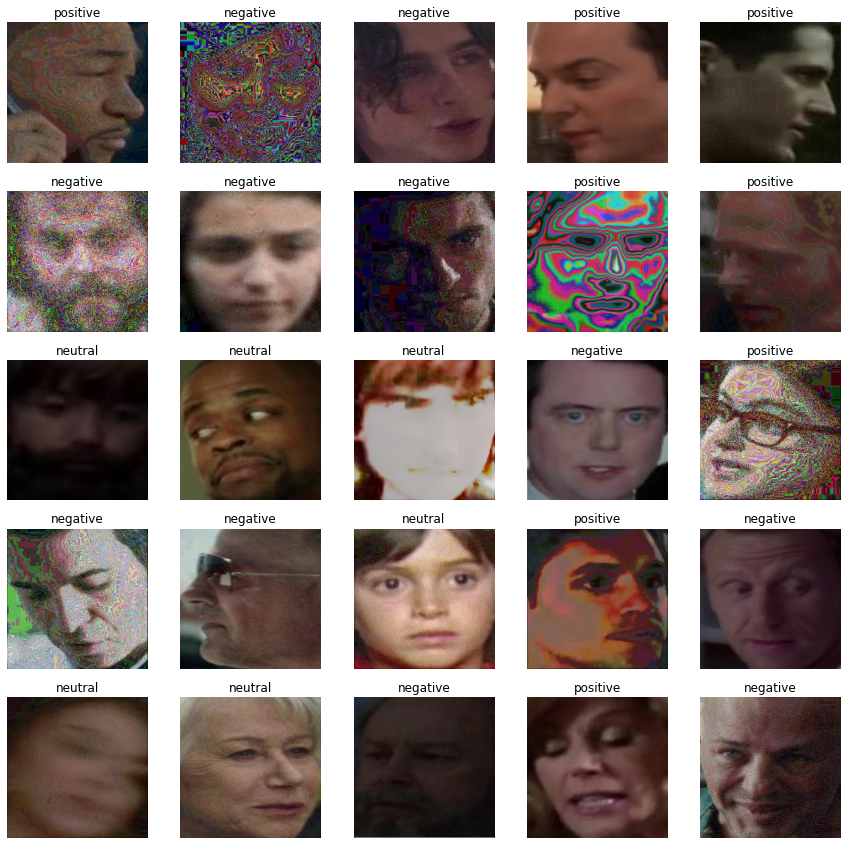

In [108]:
# show some images from the train set
def plot_random_images(dataset, num_cols, num_rows):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3))
    for i in range(num_rows):
        for j in range(num_cols):
            index = np.random.randint(len(dataset))
            image, sentiment = dataset[index]
            image = image.numpy()
            image = np.transpose(image, (1, 2, 0))
            image = image * np.array([0.1362, 0.1126, 0.1050]) + np.array([0.3351, 0.2359, 0.2032])
            image = np.clip(image, 0, 1)
            axes[i, j].imshow(image)
            # set title to positive if sentiment is 2, negative if 1, and neutral if 0
            axes[i, j].set_title('positive' if sentiment == 2 else 'negative' if sentiment == 1 else 'neutral')
            axes[i, j].axis('off')
    plt.show()

plot_random_images(train_dataset_face_aug, 5, 5)

In [44]:
# use model trained on the original data to evaluate on the augmented data
# define a funcion that takes as input the model, the data loader, and the device and gives the accuracy of the model on the data loader
# evaluate the model on the test set
def get_accuracy(model, data_loader, device, data_set_name):
    model.eval()
    test_correct = 0
    len_data = 0
    with torch.no_grad():
        for i, (image, sentiment) in enumerate(data_loader):
           image = image.to(device)
           len_data = len_data + len(image)
           sentiment = sentiment.to(device)
           output = model(image)
           test_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
    test_acc = test_correct / len_data
    print(f"{data_set_name} accuracy: {test_acc}")
    return test_acc

aug_train_acc = get_accuracy(model, train_loader_face_aug, device, 'augmented_train_data')
aug_dev_acc = get_accuracy(model, dev_loader_face_aug, device, 'augmented_dev_data')
aug_test_acc = get_accuracy(model, test_loader_face_aug, device, 'augmented_test_data')

augmented_train_data accuracy: 0.3774196128619421
augmented_dev_data accuracy: 0.36496230744018354
augmented_test_data accuracy: 0.3686061381074169


### Step 3

In [45]:
# create a new dataset that combines the original and augmented data
# define the data loaders for the combined train, dev, and test sets
class CombinedCroppedFaces(Dataset):
    def __init__(self, dataset, dataset_aug, transform=None):
        self.dataset = dataset
        self.dataset_aug = dataset_aug
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset) + len(self.dataset_aug)

    def __getitem__(self, idx):
        if idx < len(self.dataset):
            image, sentiment = self.dataset[idx]
        else:
            image, sentiment = self.dataset_aug[idx - len(self.dataset)]
        if self.transform:
            image = self.transform(image)
        return image, sentiment

In [46]:
# create instances of the custom dataset class for the train, dev, and test sets
# define the data loaders for the train, dev, and test sets
# define the image transform for the train, dev, and test sets

train_dataset_face_full = CombinedCroppedFaces(train_dataset_face, train_dataset_face_aug)
dev_dataset_face_full = CombinedCroppedFaces(dev_dataset_face, dev_dataset_face_aug)
test_dataset_face_full = CombinedCroppedFaces(test_dataset_face, test_dataset_face_aug)

train_loader_face_full = DataLoader(train_dataset_face_full, batch_size=32, shuffle=True)
dev_loader_face_full = DataLoader(dev_dataset_face_full, batch_size=32, shuffle=False)
test_loader_face_full = DataLoader(test_dataset_face_full, batch_size=32, shuffle=False)

In [47]:
# Instantiate the model, move it to device, and define the optimizer and loss function
model = timm.create_model('resnet18', pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 3)
)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
model = model.to(device)
# comment the below 2 lines if you want to retrain the model
!gdown 1--TrIh-gMhDIEWUXdOoZxUiNkLQ3CNFO
model.load_state_dict(torch.load('combined_face_sentiment_classifier.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
loss_function = nn.CrossEntropyLoss()

Downloading...
From: https://drive.google.com/uc?id=1--TrIh-gMhDIEWUXdOoZxUiNkLQ3CNFO
To: /content/combined_face_sentiment_classifier.pt
100% 45.3M/45.3M [00:00<00:00, 176MB/s]


In [ ]:
# train_losses, train_accs, dev_losses, dev_accs = train(model, train_loader_face_full, dev_loader_face_full, optimizer, loss_function, num_epochs=10)
# torch.save(model.state_dict(), 'combined_face_sentiment_classifier.pt')

Epoch 1/10
Train loss: 1.0955843854545404, train accuracy: 0.3636018237082067
Dev loss: 1.0901427240895976, dev accuracy: 0.36250409701737135
Epoch 2/10
Train loss: 1.091208039379547, train accuracy: 0.3758998560230363
Dev loss: 1.0884005964114405, dev accuracy: 0.3678302196001311
Epoch 3/10
Train loss: 1.0905406635995867, train accuracy: 0.3791793313069909
Dev loss: 1.0883528184516267, dev accuracy: 0.3678302196001311
Epoch 4/10
Train loss: 1.0900534072596526, train accuracy: 0.380859062549992
Dev loss: 1.0890488607409112, dev accuracy: 0.3660275319567355
Epoch 5/10
Train loss: 1.0897655374944324, train accuracy: 0.38111902095664696
Dev loss: 1.0889693487689134, dev accuracy: 0.3678302196001311
Epoch 6/10
Train loss: 1.0894978353783478, train accuracy: 0.38321868501039835
Dev loss: 1.0891816626980666, dev accuracy: 0.36561783021960015
Epoch 7/10
Train loss: 1.0893387130186944, train accuracy: 0.38477843545032797
Dev loss: 1.0892774470501545, dev accuracy: 0.36545394952474597
Epoch 8/1

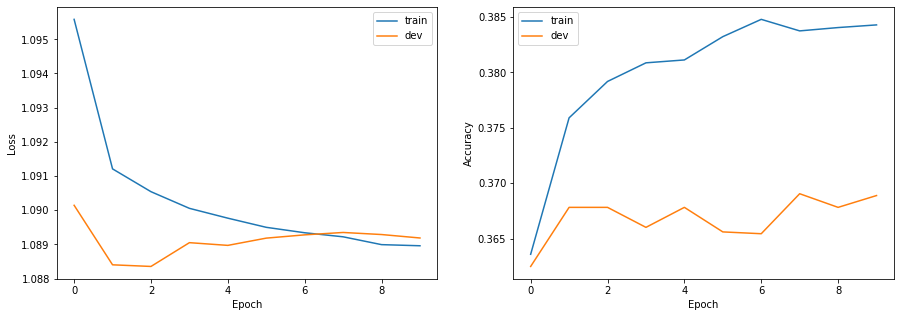

In [ ]:
# define a function that given the train_losses, train_accs, dev_losses, and dev_accs, plots the train and dev losses and accuracies
def plot_train_dev(train_losses, train_accs, dev_losses, dev_accs):
    # TODO: implement this function
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(train_losses, label='train')
    axes[0].plot(dev_losses, label='dev')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(train_accs, label='train')
    axes[1].plot(dev_accs, label='dev')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.show()
# plot_train_dev(train_losses, train_accs, dev_losses, dev_accs)

In [48]:
# evaluate the model on the test set
combind_test_acc = get_accuracy(model, test_loader_face_full, device, 'combind_test_data')

combind_test_data accuracy: 0.3908248081841432


In [49]:
face_detector = MTCNN(keep_all=True, device=device)
# the input image is of size (height, width, channels) and uint8
# the output image should be of size (channels, height, width) and float32 and normalized to [-1, 1]
face_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.permute(2, 0, 1)),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3351, 0.2359, 0.2032], std=[0.1362, 0.1126, 0.1050])
])
face_sentiment_counter = FaceSentimentCounter(face_detector, model, face_transform)

In [58]:
train_predictions = []
train_sentiments = []
for i, (image, sentiment) in enumerate(train_loader_MSCTD):
    print(f"Processing batch {i+1}") if i % 50 == 0 else None
    image = image.to(device)
    sentiment = sentiment.to(device)
    prediction = face_sentiment_counter(image)
    train_predictions.append(prediction)
    train_sentiments.append(sentiment.cpu())
train_predictions = torch.cat(train_predictions, dim=0)
train_sentiments = torch.cat(train_sentiments, dim=0)

dev_predictions = []
dev_sentiments = []
for i, (image, sentiment) in enumerate(dev_loader_MSCTD):
    print(f"Processing batch {i+1}") if i % 50 == 0 else None
    image = image.to(device)
    sentiment = sentiment.to(device)
    prediction = face_sentiment_counter(image)
    dev_predictions.append(prediction)
    dev_sentiments.append(sentiment.cpu())
dev_predictions = torch.cat(dev_predictions, dim=0)
dev_sentiments = torch.cat(dev_sentiments, dim=0)

test_predictions = []
test_sentiments = []
for i, (image, sentiment) in enumerate(test_loader_MSCTD):
    print(f"Processing batch {i+1}") if i % 50 == 0 else None
    image = image.to(device)
    sentiment = sentiment.to(device)
    prediction = face_sentiment_counter(image)
    test_predictions.append(prediction)
    test_sentiments.append(sentiment.cpu())
test_predictions = torch.cat(test_predictions, dim=0)
test_sentiments = torch.cat(test_sentiments, dim=0)

Processing batch 1
Processing batch 51
Processing batch 101
Processing batch 151
Processing batch 201
Processing batch 251
Processing batch 301
Processing batch 351
Processing batch 401
Processing batch 451
Processing batch 501
Processing batch 551
Processing batch 601
Processing batch 1
Processing batch 51
Processing batch 101
Processing batch 151
Processing batch 1
Processing batch 51
Processing batch 101
Processing batch 151


In [59]:
!gdown 1-2Gbk7xpyHyngflsCPKtHvZq_bdsDiRI #train combined
!gdown 1-0IuxitsbXoXfJia-VcTLBR3E1cONCDx #dev combined
!gdown 1-4eD-ZTQw0DDoO-E7-6g5DH_5P9A1FvX #test combined
# normalize the predictions by subtracting the mean and dividing by the standard deviation
# train_predictions_normalized = (train_predictions.float() - train_predictions.float().mean(dim=0)) / train_predictions.float().std(dim=0)
# # # normalize dev and test predictions by the mean and standard deviation of the training set
# dev_predictions_normalized = (dev_predictions.float() - train_predictions.float().mean(dim=0)) / train_predictions.float().std(dim=0)
# test_predictions_normalized = (test_predictions.float() - train_predictions.float().mean(dim=0)) / train_predictions.float().std(dim=0)

# make data loaders for the predictions and sentiments
# train_dataset = torch.utils.data.TensorDataset(train_predictions_normalized, train_sentiments)
train_dataset = torch.load("train_dataset_part1.pt")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# dev_dataset = torch.utils.data.TensorDataset(dev_predictions_normalized, dev_sentiments)
dev_dataset = torch.load("dev_dataset_part1.pt")
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False)
# test_dataset = torch.utils.data.TensorDataset(test_predictions_normalized, test_sentiments)
test_dataset = torch.load("test_dataset_part1.pt")
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# save train_dataset, dev_dataset, test_dataset
# torch.save(train_dataset, "train_dataset_part1.pt")
# torch.save(dev_dataset, "dev_dataset_part1.pt")
# torch.save(test_dataset, "test_dataset_part1.pt")
     

Downloading...
From: https://drive.google.com/uc?id=1-2Gbk7xpyHyngflsCPKtHvZq_bdsDiRI
To: /content/train_dataset_part1.pt
100% 406k/406k [00:00<00:00, 16.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0IuxitsbXoXfJia-VcTLBR3E1cONCDx
To: /content/dev_dataset_part1.pt
100% 102k/102k [00:00<00:00, 90.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-4eD-ZTQw0DDoO-E7-6g5DH_5P9A1FvX
To: /content/test_dataset_part1.pt
100% 102k/102k [00:00<00:00, 67.7MB/s]


In [60]:
# define the model
sentiment_classifier = MLP(3, 20, 3)
sentiment_classifier = sentiment_classifier.to(device)

# define the loss function
loss_function = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.Adam(sentiment_classifier.parameters(), lr=1e-4)

n_epochs = 10
train_losses = []
train_accs = []
dev_losses = []
dev_accs = []
for epoch in range(n_epochs):
    # train
    sentiment_classifier.train()
    train_loss = 0
    train_correct = 0
    for i, (prediction, sentiment) in enumerate(train_loader):
        prediction = prediction.to(device)
        sentiment = sentiment.to(device)
        optimizer.zero_grad()
        output = sentiment_classifier(prediction.float())
        loss = loss_function(output, sentiment)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
    train_loss /= len(train_loader)
    train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # dev
    sentiment_classifier.eval()
    dev_loss = 0
    dev_correct = 0
    with torch.no_grad():
        for i, (prediction, sentiment) in enumerate(dev_loader):
            prediction = prediction.to(device)
            sentiment = sentiment.to(device)
            output = sentiment_classifier(prediction.float())
            loss = loss_function(output, sentiment)
            dev_loss += loss.item()
            dev_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
    dev_loss /= len(dev_loader)
    dev_acc = dev_correct / len(dev_loader.dataset)
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)
    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
    print(f"Dev loss: {dev_loss:.4f}, Dev acc: {dev_acc:.4f}")

Epoch 1/10
Train loss: 1.1252, Train acc: 0.2747
Dev loss: 1.1154, Dev acc: 0.2905
Epoch 2/10
Train loss: 1.1179, Train acc: 0.2752
Dev loss: 1.1098, Dev acc: 0.2905
Epoch 3/10
Train loss: 1.1121, Train acc: 0.2806
Dev loss: 1.1055, Dev acc: 0.2935
Epoch 4/10
Train loss: 1.1072, Train acc: 0.2886
Dev loss: 1.1022, Dev acc: 0.3034
Epoch 5/10
Train loss: 1.1032, Train acc: 0.3362
Dev loss: 1.0995, Dev acc: 0.3727
Epoch 6/10
Train loss: 1.1000, Train acc: 0.3823
Dev loss: 1.0976, Dev acc: 0.3727
Epoch 7/10
Train loss: 1.0974, Train acc: 0.3820
Dev loss: 1.0962, Dev acc: 0.3727
Epoch 8/10
Train loss: 1.0956, Train acc: 0.3822
Dev loss: 1.0953, Dev acc: 0.3727
Epoch 9/10
Train loss: 1.0936, Train acc: 0.3825
Dev loss: 1.0947, Dev acc: 0.3727
Epoch 10/10
Train loss: 1.0924, Train acc: 0.3825
Dev loss: 1.0943, Dev acc: 0.3727


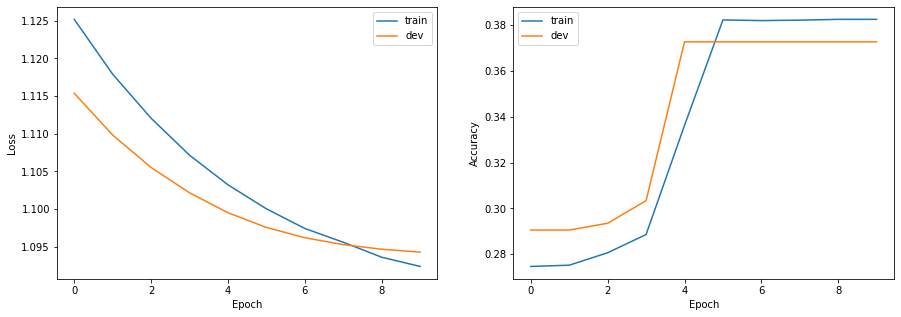

In [61]:
# define a function that given the train_losses, train_accs, dev_losses, and dev_accs, plots the train and dev losses and accuracies
def plot_train_dev(train_losses, train_accs, dev_losses, dev_accs):
    # TODO: implement this function
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(train_losses, label='train')
    axes[0].plot(dev_losses, label='dev')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(train_accs, label='train')
    axes[1].plot(dev_accs, label='dev')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.show()
plot_train_dev(train_losses, train_accs, dev_losses, dev_accs)

In [62]:
# train
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
train_predictions_part1 = []
sentiment_classifier.eval()
train_correct = 0
with torch.no_grad():
    for i, (prediction, sentiment) in enumerate(train_loader):
        prediction = prediction.to(device)
        sentiment = sentiment.to(device)
        output = sentiment_classifier(prediction.float())
        train_predictions_part1.append(torch.argmax(output, dim=1).cpu())
        train_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
train_acc = train_correct / len(train_loader.dataset)
print(f"Train acc: {train_acc:.4f}")
# dev
dev_predictions_part1 = []
sentiment_classifier.eval()
dev_correct = 0
with torch.no_grad():
    for i, (prediction, sentiment) in enumerate(dev_loader):
        prediction = prediction.to(device)
        sentiment = sentiment.to(device)
        output = sentiment_classifier(prediction.float())
        dev_predictions_part1.append(torch.argmax(output, dim=1).cpu())
        dev_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
dev_acc = dev_correct / len(dev_loader.dataset)
print(f"Dev acc: {dev_acc:.4f}")
# test
test_predictions_part1 = []
sentiment_classifier.eval()
test_correct = 0
with torch.no_grad():
    for i, (prediction, sentiment) in enumerate(test_loader):
        prediction = prediction.to(device)
        sentiment = sentiment.to(device)
        output = sentiment_classifier(prediction.float())
        test_predictions_part1.append(torch.argmax(output, dim=1).cpu())
        test_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
test_acc = test_correct / len(test_loader.dataset)
print(f"Test acc: {test_acc:.4f}")

Train acc: 0.3826
Dev acc: 0.3727
Test acc: 0.3691


In [63]:
train_predictions_part1 = torch.cat(train_predictions_part1, dim=0)
dev_predictions_part1 = torch.cat(dev_predictions_part1, dim=0)
test_predictions_part1 = torch.cat(test_predictions_part1, dim=0)
train_face_count = train_predictions.sum(1)
dev_face_count = dev_predictions.sum(1)
test_face_count = test_predictions.sum(1)

# Part 2

### Step 1

In [70]:
# Use on of the architectures from https://pytorch.org/vision/stable/models.html or any other architecture to train the model on the combined dataset
# define the model, move it to device, and define the optimizer and loss function
# change the model architecture to be able to classify 3 classes
# model_Part2 = timm.create_model('resnet18', pretrained=True)
# model_Part2.fc = nn.Sequential(
#     nn.Linear(model_Part2.fc.in_features, 256),
#     nn.ReLU(),
#     nn.Linear(256, 3)
# )
# for param in model_Part2.parameters():
#     param.requires_grad = False
# for param in model_Part2.fc.parameters():
#     param.requires_grad = True
!gdown 1-5F47VS7c9EsUtrkD5R5V4PL99GRvD8J
model_Part2 = torch.load('model_Part2.pt')
model_Part2 = model_Part2.to(device)

optimizer = torch.optim.Adam(model_Part2.parameters(), lr=1e-6)
loss_function = nn.CrossEntropyLoss()

Downloading...
From: https://drive.google.com/uc?id=1-5F47VS7c9EsUtrkD5R5V4PL99GRvD8J
To: /content/model_Part2.pt
100% 45.3M/45.3M [00:00<00:00, 255MB/s]


### Step 2

In [71]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
MSCTD_train = MSCTD(root='.', split='train', image_transform=image_transform, has_data={'image': True, 'text': False})
MSCTD_dev = MSCTD(root='.', split='dev', image_transform=image_transform, has_data={'image': True, 'text': False})
MSCTD_test = MSCTD(root='.', split='test', image_transform=image_transform, has_data={'image': True, 'text': False})
# Define data loaders for the train, dev, and test sets from MSCTD
batch_size = 32
train_loader_MSCTD = DataLoader(MSCTD_train, batch_size=batch_size, shuffle=True)
dev_loader_MSCTD = DataLoader(MSCTD_dev, batch_size=batch_size, shuffle=False)
test_loader_MSCTD = DataLoader(MSCTD_test, batch_size=batch_size, shuffle=False)

### Step 3

In [ ]:
n_epochs = 10
train_losses = []
train_accs = []
dev_losses = []
dev_accs = []
for epoch in range(n_epochs):
    # train
    model_Part2.train()
    train_loss = 0
    train_correct = 0
    for i, (image, sentiment) in enumerate(train_loader_MSCTD):
        image = image.to(device)
        sentiment = sentiment.to(device)
        output = model_Part2(image.float())
        loss = loss_function(output, sentiment)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
    train_loss /= len(train_loader_MSCTD)
    train_acc = train_correct / len(train_loader_MSCTD.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # dev
    model_Part2.eval()
    dev_loss = 0
    dev_correct = 0
    with torch.no_grad():
        for i, (image, sentiment) in enumerate(dev_loader_MSCTD):
            image = image.to(device)
            sentiment = sentiment.to(device)
            output = model_Part2(image.float())
            loss = loss_function(output, sentiment)
            dev_loss += loss.item()
            dev_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
    dev_loss /= len(dev_loader_MSCTD)
    dev_acc = dev_correct / len(dev_loader_MSCTD.dataset)
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)

    print(f"Epoch: {epoch+1}/{n_epochs}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Dev loss: {dev_loss:.4f}, Dev acc: {dev_acc:.4f}")
        

Epoch: 1/10, Train loss: 1.1056, Train acc: 0.3366, Dev loss: 1.1007, Dev acc: 0.3579
Epoch: 2/10, Train loss: 1.0961, Train acc: 0.3645, Dev loss: 1.1000, Dev acc: 0.3607
Epoch: 3/10, Train loss: 1.0948, Train acc: 0.3716, Dev loss: 1.1001, Dev acc: 0.3622
Epoch: 4/10, Train loss: 1.0932, Train acc: 0.3786, Dev loss: 1.0994, Dev acc: 0.3650
Epoch: 5/10, Train loss: 1.0921, Train acc: 0.3797, Dev loss: 1.0991, Dev acc: 0.3652
Epoch: 6/10, Train loss: 1.0913, Train acc: 0.3809, Dev loss: 1.0987, Dev acc: 0.3652
Epoch: 7/10, Train loss: 1.0906, Train acc: 0.3825, Dev loss: 1.0988, Dev acc: 0.3616
Epoch: 8/10, Train loss: 1.0895, Train acc: 0.3842, Dev loss: 1.0981, Dev acc: 0.3612
Epoch: 9/10, Train loss: 1.0894, Train acc: 0.3863, Dev loss: 1.0983, Dev acc: 0.3624
Epoch: 10/10, Train loss: 1.0885, Train acc: 0.3903, Dev loss: 1.0975, Dev acc: 0.3666


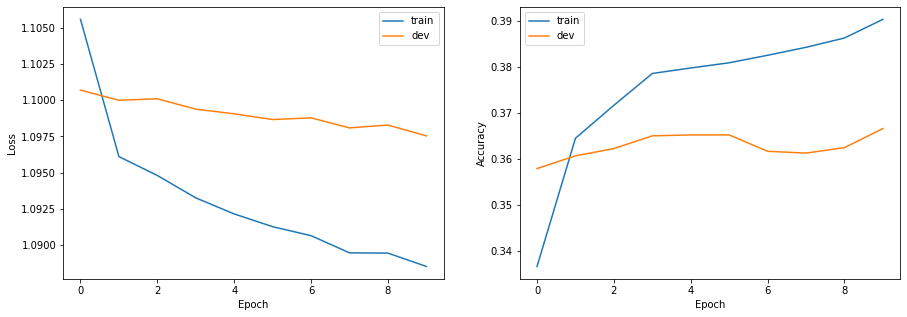

In [ ]:
# plot the train and dev losses and accuracies
plot_train_dev(train_losses, train_accs, dev_losses, dev_accs)

In [ ]:
# torch.save(model_Part2, "model_Part2.pt")

In [72]:
train_loader_MSCTD = DataLoader(MSCTD_train, batch_size=batch_size, shuffle=False)
model_Part2.eval()
train_correct = 0
train_predictions_part2 = []
with torch.no_grad():
    for i, (image, sentiment) in enumerate(train_loader_MSCTD):
        image = image.to(device)
        sentiment = sentiment.to(device)
        output = model_Part2(image.float())
        loss = loss_function(output, sentiment)
        train_predictions_part2.append(torch.argmax(output, dim=1).cpu())
        train_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
train_acc = train_correct / len(train_loader_MSCTD.dataset)
print(f"Train acc: {train_acc:.4f}")

dev_correct = 0
dev_predictions_part2 = []
with torch.no_grad():
    for i, (image, sentiment) in enumerate(dev_loader_MSCTD):
        image = image.to(device)
        sentiment = sentiment.to(device)
        output = model_Part2(image.float())
        loss = loss_function(output, sentiment)
        dev_predictions_part2.append(torch.argmax(output, dim=1).cpu())
        dev_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
dev_acc = dev_correct / len(dev_loader_MSCTD.dataset)
print(f"Dev acc: {dev_acc:.4f}")

# test the model on the test set
test_correct = 0
test_predictions_part2 = []
with torch.no_grad():
    for i, (image, sentiment) in enumerate(test_loader_MSCTD):
        image = image.to(device)
        sentiment = sentiment.to(device)
        output = model_Part2(image.float())
        loss = loss_function(output, sentiment)
        test_predictions_part2.append(torch.argmax(output, dim=1).cpu())
        test_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
test_acc = test_correct / len(test_loader_MSCTD.dataset)
print(f"Test acc: {test_acc:.4f}")


Train acc: 0.3914
Dev acc: 0.3666
Test acc: 0.3894


# Part 3

In [73]:
train_predictions_part2 = torch.cat(train_predictions_part2, dim=0)
dev_predictions_part2 = torch.cat(dev_predictions_part2, dim=0)
test_predictions_part2 = torch.cat(test_predictions_part2, dim=0)

In [ ]:
!gdown 1--veWsNQT-a2kkdKahcY9rAmhIjIXvWv
!gdown 1pwWlUfhMWNmxL3tz8qK7ajq1Hr3kpW6v
!gdown 1-0_83uSMsKhlecyL9MiVxWwf8rt0gwvQ
trainset = torch.load("train_dataset_last.pt")
devset = torch.load("dev_dataset_last.pt")
testset = torch.load("test_dataset_last.pt")
trainloader = DataLoader(trainset, batch_size=32, shuffle=False)
devloader = DataLoader(devset, batch_size=32, shuffle=False)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [74]:
# train_sentiment = torch.tensor(MSCTD_train.sentiment)
# dev_sentiment = torch.tensor(MSCTD_dev.sentiment)
# test_sentiment = torch.tensor(MSCTD_test.sentiment)
# trainset_x = torch.cat([train_face_count.unsqueeze(1), train_predictions_part1.unsqueeze(1), train_predictions_part2.unsqueeze(1)], dim=1)
# devset_x = torch.cat([dev_face_count.unsqueeze(1), dev_predictions_part1.unsqueeze(1), dev_predictions_part2.unsqueeze(1)], dim=1)
# testset_x = torch.cat([test_face_count.unsqueeze(1), test_predictions_part1.unsqueeze(1), test_predictions_part2.unsqueeze(1)], dim=1)
# trainset = torch.utils.data.TensorDataset(trainset_x, train_sentiment)
# devset = torch.utils.data.TensorDataset(devset_x, dev_sentiment)
# testset = torch.utils.data.TensorDataset(testset_x, test_sentiment)

# trainloader = DataLoader(trainset, batch_size=32, shuffle=False)
# devloader = DataLoader(devset, batch_size=32, shuffle=False)
# testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [75]:
# torch.save(trainset, "train_dataset_last.pt")
# torch.save(devset, "dev_dataset_last.pt")
# torch.save(testset, "test_dataset_last.pt")

In [104]:
# Use on of the architectures from https://pytorch.org/vision/stable/models.html or any other architecture to train the model on the combined dataset
# define the model, move it to device, and define the optimizer and loss function
# change the model architecture to be able to classify 3 classes
model = MLP(3, 50, 3)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

In [105]:
n_epochs = 10
train_losses = []
train_accs = []
dev_losses = []
dev_accs = []
for epoch in range(n_epochs):
    # train
    model.train()
    train_loss = 0
    train_correct = 0
    for i, (x, sentiment) in enumerate(trainloader):
        x = x.to(device)
        sentiment = sentiment.to(device)
        output = model(x.float())
        loss = loss_function(output, sentiment)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
    train_loss /= len(trainloader)
    train_acc = train_correct / len(trainset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # dev
    model.eval()
    dev_loss = 0
    dev_correct = 0
    with torch.no_grad():
        for i, (x, sentiment) in enumerate(devloader):
            x = x.to(device)
            sentiment = sentiment.to(device)
            output = model(x.float())
            loss = loss_function(output, sentiment)
            dev_loss += loss.item()
            dev_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
    dev_loss /= len(devloader)
    dev_acc = dev_correct / len(devset)
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)

    print(f"Epoch: {epoch+1}/{n_epochs}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Dev loss: {dev_loss:.4f}, Dev acc: {dev_acc:.4f}")
        

Epoch: 1/10, Train loss: 1.1038, Train acc: 0.3797, Dev loss: 1.1050, Dev acc: 0.3656
Epoch: 2/10, Train loss: 1.0905, Train acc: 0.3849, Dev loss: 1.1017, Dev acc: 0.3658
Epoch: 3/10, Train loss: 1.0890, Train acc: 0.3855, Dev loss: 1.1020, Dev acc: 0.3656
Epoch: 4/10, Train loss: 1.0887, Train acc: 0.3860, Dev loss: 1.1023, Dev acc: 0.3656
Epoch: 5/10, Train loss: 1.0885, Train acc: 0.3864, Dev loss: 1.1025, Dev acc: 0.3656
Epoch: 6/10, Train loss: 1.0883, Train acc: 0.3863, Dev loss: 1.1026, Dev acc: 0.3656
Epoch: 7/10, Train loss: 1.0882, Train acc: 0.3855, Dev loss: 1.1027, Dev acc: 0.3656
Epoch: 8/10, Train loss: 1.0881, Train acc: 0.3847, Dev loss: 1.1028, Dev acc: 0.3656
Epoch: 9/10, Train loss: 1.0880, Train acc: 0.3851, Dev loss: 1.1028, Dev acc: 0.3656
Epoch: 10/10, Train loss: 1.0879, Train acc: 0.3851, Dev loss: 1.1029, Dev acc: 0.3656


FINAL ACCURACY ON TEST SET

In [106]:
model.eval()
test_correct = 0
with torch.no_grad():
    for i, (x, sentiment) in enumerate(testloader):
        x = x.to(device)
        sentiment = sentiment.to(device)
        output = model(x.float())
        loss = loss_function(output, sentiment)
        test_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
test_acc = test_correct / len(testset)
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.4172
